Importing all libraries

In [138]:
import pandas as pd
import numpy as np
from surprise.model_selection import train_test_split
from sklearn.model_selection import train_test_split as tt
from sklearn.datasets import load_iris
import math
import re
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from surprise.model_selection import cross_validate as cv
from surprise.model_selection import GridSearchCV
from math import sqrt
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD, SVDpp, NMF, KNNBaseline, KNNBasic, KNNWithZScore, BaselineOnly
from surprise import Dataset
from surprise import accuracy
from surprise import SlopeOne, CoClustering
sns.set_style("darkgrid")

In [139]:
ratings= pd.read_csv('C:\\Users\\shrut\\OneDrive\\Desktop\\Dissertation\\state_rating.csv')
ratings.head()

,state_id,state,avg_rating,movie
0,1,AK,3,1
1,1,AK,4,2
2,1,AK,4,3
3,1,AK,3,4
4,1,AK,4,7


# Data viewing

In [140]:
user_df=pd.read_csv('C:\\Users\\shrut\\OneDrive\\Desktop\\Dissertation\\user_geo.csv')

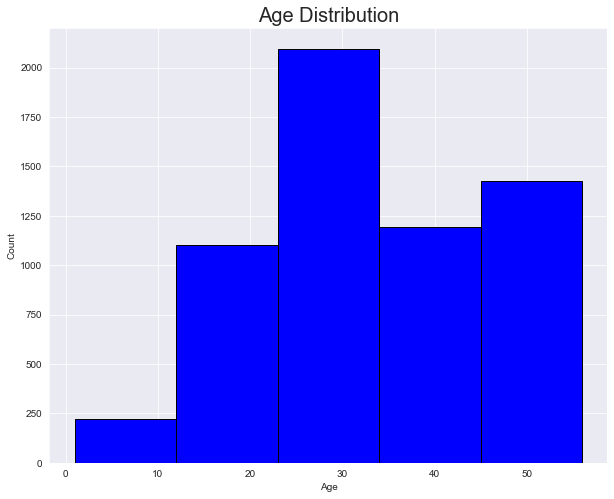

In [141]:
plt.figure(figsize=(10,8))
plt.hist(user_df['age'], color = 'blue', edgecolor = 'black',
         bins = 5, )
plt.title('Age Distribution', fontsize=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

The maximum ratings have been recieved by people in the age group 30 and minimum by the people in the age group of 0-10

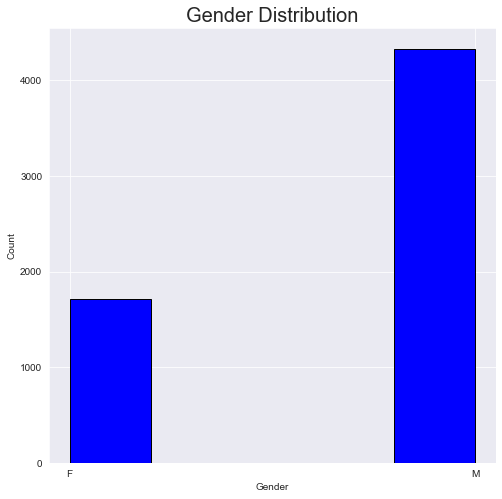

In [142]:
plt.figure(figsize=(8,8))
plt.hist(user_df['gender'], color = 'blue', edgecolor = 'black',
         bins = 5, )
plt.title('Gender Distribution', fontsize=20)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

Movies with max rating 

Males have rated 60% more movies than females. total count of Female ratings = 1709 and the total count of male movies = 4331

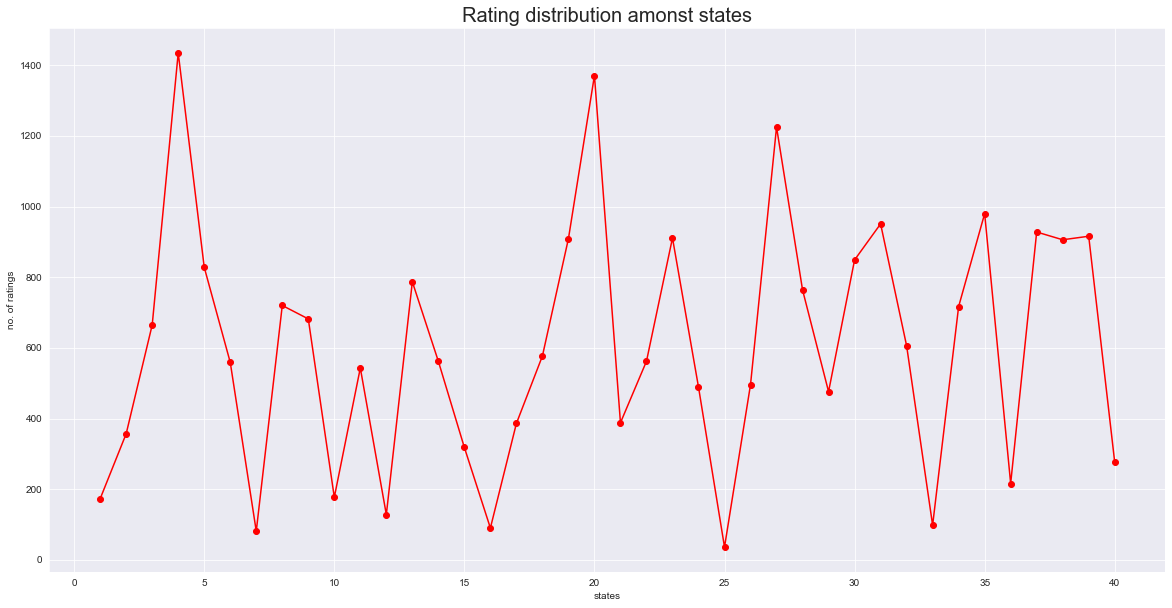

In [143]:
rating_count=ratings.groupby(by=['state_id']).count().drop(columns=['state', 'movie'])
plt.figure(figsize=(20,10))
y=rating_count.iloc[:,0]
plt.plot(y, color='red', marker='o')
plt.title('Rating distribution amonst states', fontsize=20)
plt.xlabel("states")
plt.ylabel('no. of ratings')
plt.show()

From the graph above we see that state_ids 4,20 and 27 have rated maximum number of movies, whereas state_id 7,16, 25, and 33 have rated the least  

In [144]:
p = ratings.groupby(['avg_rating']).agg(['count'])
movie_count = ratings.movie.max()
cust_count = ratings['state_id'].nunique()
rating_count=(ratings.avg_rating!=0).sum()

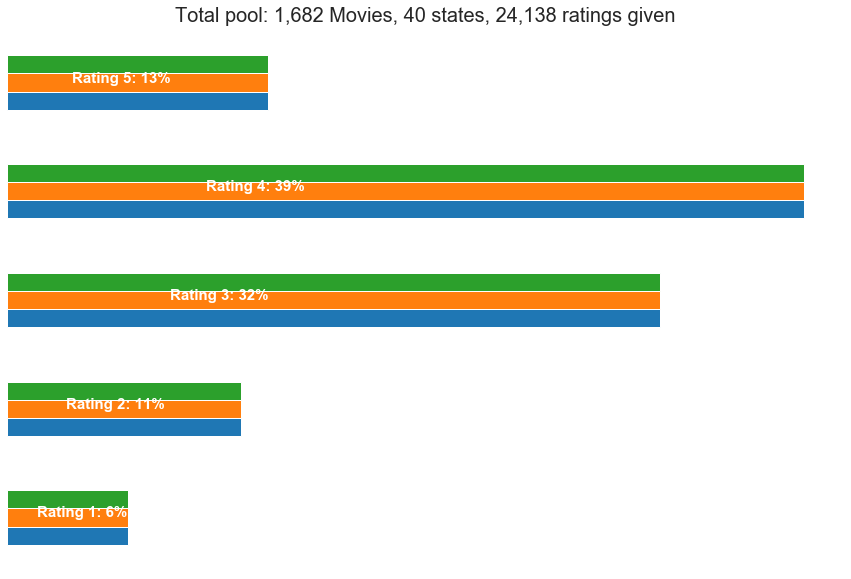

In [145]:
ax = p.plot(kind='barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} states, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold', fontsize=15)

# Data Trimming

In [146]:
f = ['count','mean']

df_movie_summary = ratings.groupby('movie')['avg_rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.95),0) #only popular movies
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index
print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = ratings.groupby('state_id')['avg_rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(str)
cust_benchmark = round(df_cust_summary['count'].quantile(0.0),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index
print('State minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 32.0
State minimum times of review: 36.0


In [147]:
print('Original Shape: {}'.format(ratings.shape))
ratings = ratings[~ratings['movie'].isin(drop_movie_list)]
print('After Trim Shape: {}'.format(ratings.shape))
print('-Data Examples-')
print(ratings.iloc[::5000000, :])

Original Shape: (24138, 4)
After Trim Shape: (3941, 4)
-Data Examples-
   state_id state  avg_rating  movie
0         1    AK           3      1


# Evaluating RMSE for our Prediction

# (i) Memory Based CF

In [148]:
ratings2=ratings.copy()
ratings2=ratings2.drop(columns='state')

In [149]:
col=['state_id', 'movie']

In [150]:
for c in col:
    ratings2[c].replace({val: i for i, val in enumerate(ratings2[c].unique())}, inplace=True)

In [151]:
ratings2[:2]

,state_id,avg_rating,movie
0,0,3,0
1,0,4,1


In [152]:
n_users=int(ratings2.state_id.nunique())
n_items=int(ratings2.movie.nunique())

In [153]:
trainSet, testSet = tt(ratings2, test_size=0.25)

In [154]:
#Create two user-item matrices, one for training and another for testing
state_movies_pivot_train = trainSet.pivot(index='state_id', columns='movie', values='avg_rating').fillna(0)
state_movies_pivot_train

movie,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,114
state_id,,,,,,,,,,,,,,,,,,,,,
0,3.0,4.0,4.0,0.0,0.0,3.0,0.0,5.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,4.0,5.0,4.0,0.0,5.0,0.0,0.0,4.0,...,4.0,4.0,5.0,4.0,5.0,0.0,5.0,4.0,0.0,0.0
2,5.0,3.0,0.0,4.0,4.0,4.0,0.0,4.0,0.0,4.0,...,0.0,0.0,5.0,0.0,5.0,5.0,5.0,3.0,4.0,4.0
3,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,0.0,4.0,0.0,4.0,4.0,4.0,0.0,4.0,4.0
4,4.0,4.0,0.0,4.0,0.0,0.0,4.0,4.0,4.0,4.0,...,4.0,5.0,5.0,4.0,0.0,4.0,0.0,4.0,4.0,0.0
5,0.0,3.0,4.0,4.0,5.0,0.0,0.0,5.0,3.0,0.0,...,5.0,4.0,0.0,0.0,5.0,5.0,5.0,0.0,0.0,5.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,5.0,4.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0
7,4.0,3.0,0.0,5.0,0.0,3.0,5.0,0.0,4.0,3.0,...,4.0,4.0,4.0,0.0,4.0,5.0,4.0,3.0,5.0,4.0
8,4.0,3.0,0.0,4.0,0.0,4.0,0.0,0.0,4.0,4.0,...,4.0,0.0,0.0,4.0,4.0,0.0,5.0,0.0,4.0,3.0


In [155]:
state_movies_pivot_test = testSet.pivot(index='state_id', columns='movie', values='avg_rating').fillna(0)
state_movies_pivot_test

movie,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,114
state_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,4.0,5.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
2,0.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,...,5.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0
4,0.0,0.0,4.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,5.0
5,5.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,4.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,2.0,5.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,4.0,0.0,4.0,0.0,5.0,4.0,0.0,0.0,...,0.0,3.0,4.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0


# Cosine Similarity

In [156]:
#Create two user-item matrices, one for training and another for testing
trainSet_matrix = np.zeros((n_users, n_items))
for line in trainSet.itertuples():
    trainSet_matrix[line[1]-1, line[2]-1] = line[3]
    
testSet_matrix = np.zeros((n_users, n_items))
for line in testSet.itertuples():
    testSet_matrix[line[1]-1, line[2]-1] = line[3]

In [157]:
def predict(rating, similarity, type='user'):
    if type == 'user':
        mean_user_rating = rating.mean(axis=1)
        #You use np.newaxis so mean_user_rating has same format as ratings
        rating_diff = (rating - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(rating_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = rating.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [158]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(trainSet_matrix, metric='cosine')
item_similarity = pairwise_distances(trainSet_matrix.T, metric='cosine')

In [159]:
item_prediction = predict(trainSet_matrix, item_similarity, type='item')
user_prediction = predict(trainSet_matrix, user_similarity, type='user')

In [160]:
def mse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return mean_squared_error(prediction, ground_truth)

In [161]:
def mae(ground_truth, prediction):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return mean_absolute_error(ground_truth, prediction)

In [162]:
mse_u = mse(user_prediction, testSet_matrix)
mse_i = mse(item_prediction, testSet_matrix)

In [163]:
mae_u=mae(testSet_matrix, user_prediction)
mae_i= mae(testSet_matrix, item_prediction)
rmse_u=math.sqrt(mse_u)
rmse_i=math.sqrt(mse_i)

In [165]:
print('User-based CF MAE: ' , mae_u)
print('Item-based CF MAE: ' , mae_i)
print('User-based CF RMSE: ' , rmse_u)
print('Item-based CF RMSE: ' , rmse_i)

User-based CF MAE:  28.75166652897842
Item-based CF MAE:  55.87323348144031
User-based CF RMSE:  34.0796610714099
Item-based CF RMSE:  65.30421002206894


# (ii) Model Based CF

Model based Collaborative Filatering has 3 methods in it. Non Parametric Approach ising Surprise algorithm KNN. Matrix Factorization using Algorith SVD and Deep learning approach using algorithm Fastai. We are going to compare the MSE/ RMSE scores of these algorithm before we make our recommendation. 

In [166]:
benchmark = []
reader=Reader()
data1= Dataset.load_from_df(ratings2[['movie', 'avg_rating', 'state_id']], reader)
# Iterate over all algorithms
for algorithm in [KNNBaseline(), KNNBasic(),KNNWithZScore(), BaselineOnly()]:
    # Perform cross validation
    results = cv(algorithm, data1, cv=3, n_jobs=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)


In [167]:
surprise_results_knn = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [168]:
surprise_results_knn

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
BaselineOnly,18.860003,15.646179,0.002352,0.011659
KNNWithZScore,18.864044,15.649871,0.288193,2.579681
KNNBaseline,18.864187,15.650699,0.305673,2.580953
KNNBasic,18.866043,15.651999,0.257228,2.195152


In [169]:
baselineOnly_rmse= surprise_results_knn.iloc[0,0]
knnbaseline_rmse = surprise_results_knn.iloc[1,0]
knnbasic_rmse = surprise_results_knn.iloc[2,0]
knnwithzscore_rmse = surprise_results_knn.iloc[3,0]
baselineOnly_mae= surprise_results_knn.iloc[0,1]
knnbaseline_mae = surprise_results_knn.iloc[1,1]
knnbasic_mae = surprise_results_knn.iloc[2,1]
knnwithzscore_mae = surprise_results_knn.iloc[3,1]


# Matrix Factorization

In [170]:
benchmark = []
reader=Reader()
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), NMF()]:
    results = cv(algorithm, data1, cv=3, n_jobs=5, verbose=False)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)


In [171]:
surprise_results_MF = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [172]:
surprise_results_MF

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVDpp,18.859585,15.646258,2.711921,0.108640
SVD,18.860781,15.647583,0.376226,0.022354
NMF,18.896299,15.684752,0.373775,0.013800


In [173]:
svdpp_rmse=surprise_results_MF.iloc[0,0]
svd_rmse= surprise_results_MF.iloc[1,0]
nmf_rmse=surprise_results_MF.iloc[2,0]
svdpp_mae=surprise_results_MF.iloc[0,1]
svd_mae= surprise_results_MF.iloc[1,1]
nmf_mae=surprise_results_MF.iloc[2,1]

# Other techniques

In [174]:
benchmark = []
reader=Reader()
# Iterate over all algorithms
for algorithm in [SlopeOne(), CoClustering()]:
    results = cv(algorithm, data1, cv=3, n_jobs=5, verbose=False)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

In [175]:
surprise_results_other = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [176]:
surprise_results_other

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
CoClustering,18.859443,15.646615,0.094965,0.015550
SlopeOne,18.860397,15.646263,0.005237,0.049014


In [177]:
co_clust_rmse = surprise_results_other.iloc[0,0]
slop_rmse = surprise_results_other.iloc[1,0]
co_clust_mae = surprise_results_other.iloc[0,1]
slop_mae = surprise_results_other.iloc[1,1]

<IPython.core.display.Javascript object>


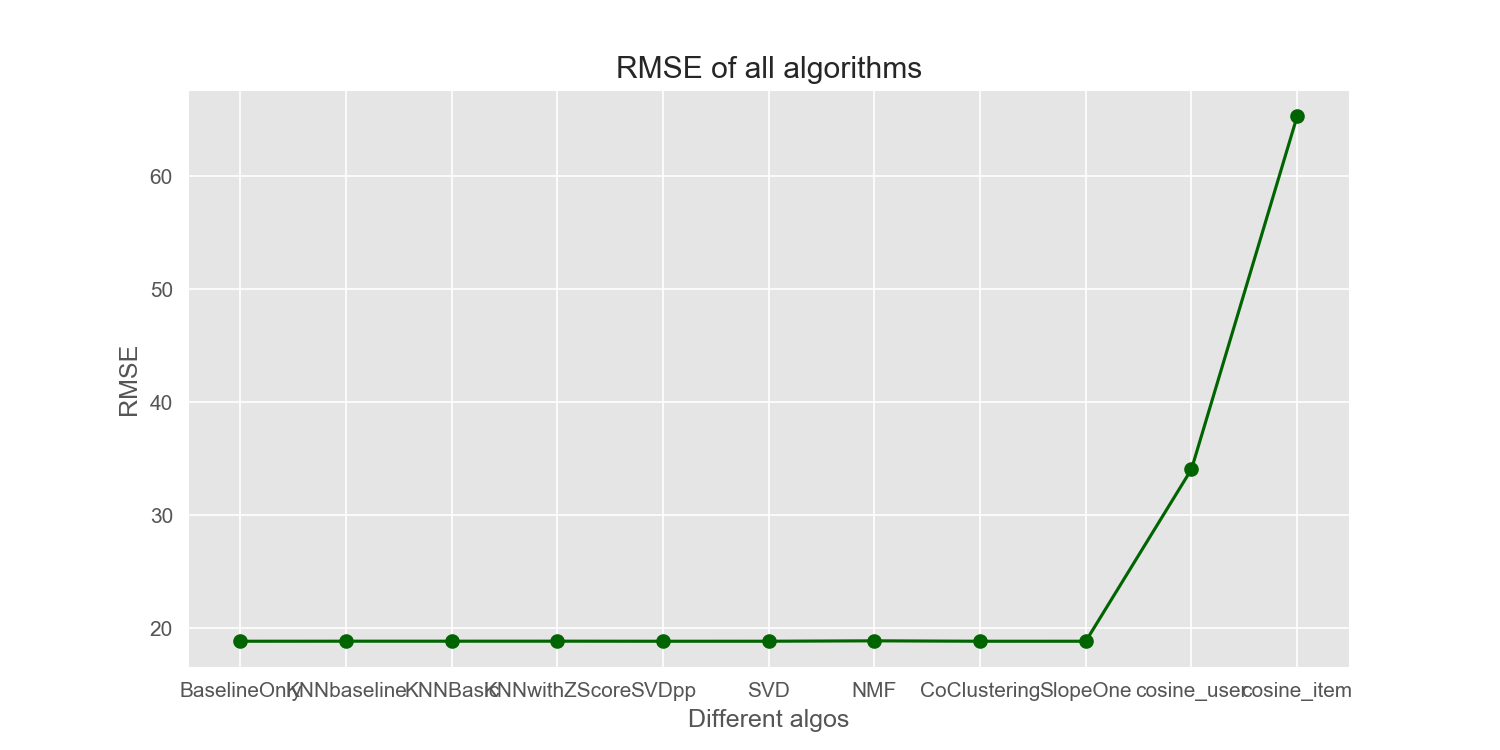

<IPython.core.display.Javascript object>


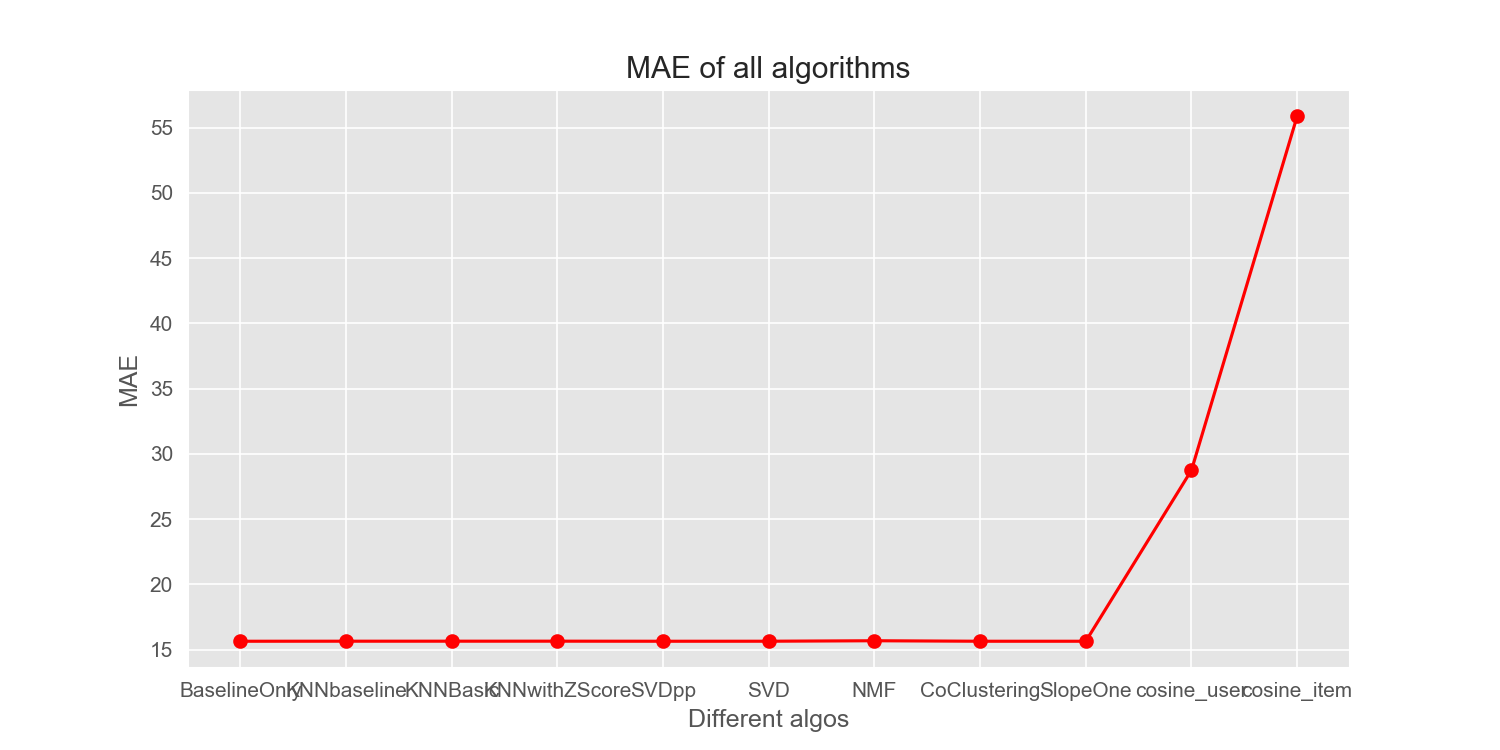

In [264]:
rmses = [baselineOnly_rmse, knnbaseline_rmse, knnbasic_rmse, knnwithzscore_rmse, svdpp_rmse, svd_rmse, nmf_rmse, co_clust_rmse, slop_rmse, rmse_u, rmse_i]
algos = ['BaselineOnly', 'KNNbaseline', 'KNNBasic', 'KNNwithZScore', 'SVDpp', 'SVD', 'NMF','CoClustering', 'SlopeOne', 'cosine_user', 'cosine_item']
plt.figure(figsize=(10,5))
plt.title('RMSE of all algorithms')
plt.plot(algos, rmses, color='darkgreen', marker='o')
plt.xlabel("Different algos")
plt.ylabel("RMSE")
plt.show()

maes = [baselineOnly_mae, knnbaseline_mae, knnbasic_mae, knnwithzscore_mae, svdpp_mae, svd_mae, nmf_mae, co_clust_mae, slop_mae, mae_u, mae_i]
algos1 = ['BaselineOnly', 'KNNbaseline', 'KNNBasic', 'KNNwithZScore', 'SVDpp', 'SVD', 'NMF','CoClustering', 'SlopeOne', 'cosine_user', 'cosine_item']
plt.figure(figsize=(10,5))
plt.title('MAE of all algorithms')
plt.plot(algos1, maes, color='red', marker='o')
plt.xlabel("Different algos")
plt.ylabel("MAE")
plt.show()

clearly cosine distance is not performing well, and hence we compare the model based algorithm

<IPython.core.display.Javascript object>


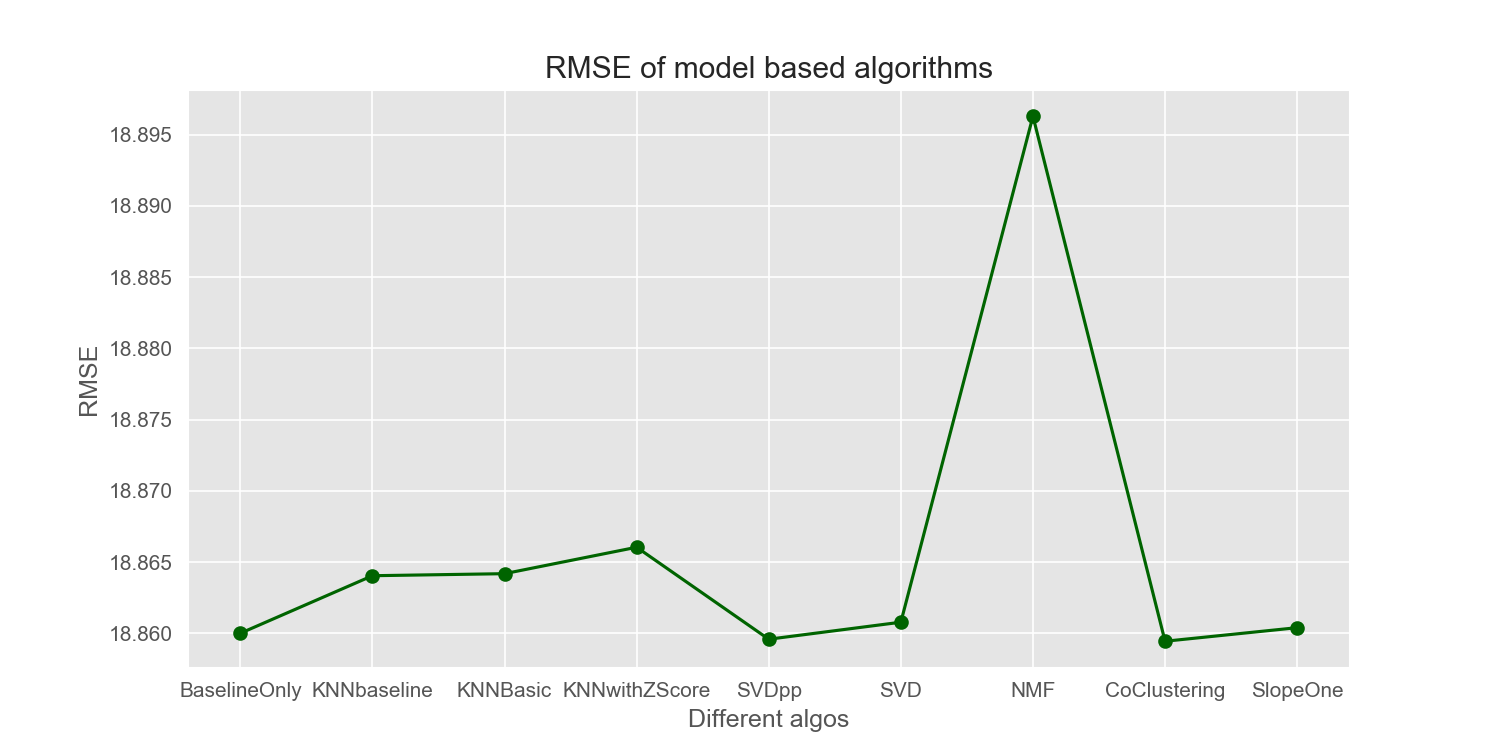

<IPython.core.display.Javascript object>


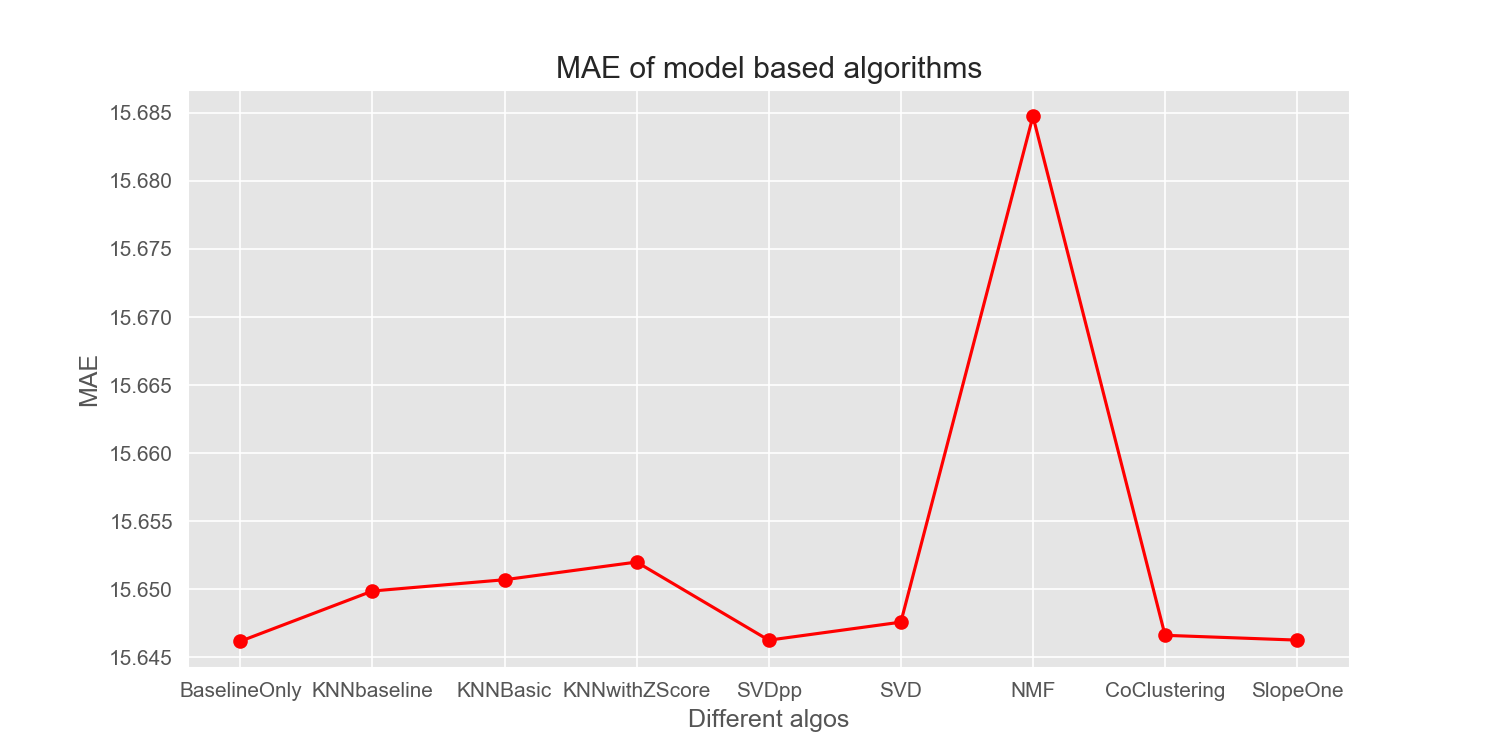

In [266]:
rmses_model = [baselineOnly_rmse, knnbaseline_rmse, knnbasic_rmse, knnwithzscore_rmse, svdpp_rmse, svd_rmse, nmf_rmse, co_clust_rmse, slop_rmse]
algos_model = ['BaselineOnly', 'KNNbaseline', 'KNNBasic', 'KNNwithZScore', 'SVDpp', 'SVD', 'NMF','CoClustering', 'SlopeOne']
plt.figure(figsize=(10,5))
plt.title('RMSE of model based algorithms')
plt.plot(algos_model, rmses_model, color='darkgreen', marker='o')
plt.xlabel("Different algos")
plt.ylabel("RMSE")
plt.show()

maes_model = [baselineOnly_mae, knnbaseline_mae, knnbasic_mae, knnwithzscore_mae, svdpp_mae, svd_mae, nmf_mae, co_clust_mae, slop_mae]
algos1__model = ['BaselineOnly', 'KNNbaseline', 'KNNBasic', 'KNNwithZScore', 'SVDpp', 'SVD', 'NMF','CoClustering', 'SlopeOne']
plt.figure(figsize=(10,5))
plt.title('MAE of model based algorithms')
plt.plot(algos1__model, maes_model, color='red', marker='o')
plt.xlabel("Different algos")
plt.ylabel("MAE")
plt.show()

The 3 best performing collaborative filtering models are: BaselineOnly, SVDpp and Co-clustering

# Perform Grid Search on BaselineOnly, SVDpp and CoClusteing

SVDpp gridsearch

In [212]:
baseonly_grid = {'bsl_options': {'method':['als','sgd'],
                                 'n_epochs': [20, 25],
                                 'lr_all': [0.006, 0.007, 0.009],
                                 'reg_all': [0.4, 0.6]}} 
# bsl_options = {'method': 'sgd'}
# algo=BaselineOnly(sgd)
baseonly_gs=GridSearchCV(BaselineOnly, baseonly_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
baseonly_gs.fit(data1)

In [213]:
print('BaselineOnly - RMSE:', round(baseonly_gs.best_score['rmse'], 4), '; MAE:', round(baseonly_gs.best_score['mae'], 4))

BaselineOnly - RMSE: 18.8585 ; MAE: 15.6463


In [214]:
svd_param_grid = {'n_epochs': [20, 25], 
                  'lr_all': [0.006, 0.007, 0.009],
                  'reg_all': [0.4, 0.6, 0.7]}
svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svdpp_gs.fit(data1)

In [215]:
print('SVDpp - RMSE:', round(svdpp_gs.best_score['rmse'], 4), '; MAE:', round(svdpp_gs.best_score['mae'], 4))

SVDpp - RMSE: 18.8588 ; MAE: 15.6463


In [216]:
coclustering_grid = {'n_cltr_u':[2,3,4],
                     'n_cltr_i':[2,3,4],
                     'n_epochs':[20, 25]
                    }
coclustering_gs = GridSearchCV(CoClustering, coclustering_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
coclustering_gs.fit(data1)

In [217]:
print('Coclustering - RMSE:', round(coclustering_gs.best_score['rmse'], 4), '; MAE:', round(coclustering_gs.best_score['mae'], 4))

Coclustering - RMSE: 18.8607 ; MAE: 15.6462


# BaselineOnly Best Params

In [223]:
print('RMSE =', baseonly_gs.best_params['rmse'])
print('MAE =', baseonly_gs.best_params['mae'])

RMSE = {'bsl_options': {'method': 'als', 'n_epochs': 20, 'lr_all': 0.006, 'reg_all': 0.4}}
MAE = {'bsl_options': {'method': 'als', 'n_epochs': 20, 'lr_all': 0.006, 'reg_all': 0.4}}


# SVDpp Best Params

In [224]:
print('RMSE =', svdpp_gs.best_params['rmse'])
print('MAE =', svdpp_gs.best_params['mae'])

RMSE = {'n_epochs': 20, 'lr_all': 0.006, 'reg_all': 0.4}
MAE = {'n_epochs': 20, 'lr_all': 0.006, 'reg_all': 0.4}


# CoClustering Best Params 

In [225]:
print('RMSE =', coclustering_gs.best_params['rmse'])
print('MAE =', coclustering_gs.best_params['mae'])

RMSE = {'n_cltr_u': 2, 'n_cltr_i': 2, 'n_epochs': 20}
MAE = {'n_cltr_u': 2, 'n_cltr_i': 2, 'n_epochs': 20}


Our final model for the recommender system is CoClustering with the parameters 'n_cltr_u': 2, 'n_cltr_i': 2, 'n_epochs': 20 

# Comparing the best and worst prediction of top 3 models

In [251]:
data_co= Dataset.load_from_df(ratings2[['state_id', 'movie', 'avg_rating']], reader)
trainset_co, testset_co = train_test_split(data_co, test_size=0.25)
algo_co = CoClustering(n_epochs= 20, n_cltr_u= 2, n_cltr_i= 2)
predictions_co = algo_co.fit(trainset_co).test(testset_co)
accuracy.rmse(predictions_co)

RMSE: 0.6949


0.6949332329739681

Best and worst prediction of Co-clustering

In [252]:
#code taken from https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b
def get_Iu(uid):
    try:
        return len(trainset_co.ur[trainset_co.to_inner_uid(uid)])
    except ValueError: 
        return 0
    
def get_Ui(iid):
    try: 
        return len(trainset_co.ir[trainset_co.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions_co, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions_co = df.sort_values(by='err')[:10]
worst_predictions_co = df.sort_values(by='err')[-10:]

In [253]:
best_predictions_co

,uid,iid,rui,est,details,Iu,Ui,err
161,39,107,5.0,5.000000,{'was_impossible': False},64,26,0.000000
754,6,101,4.0,3.999722,{'was_impossible': False},17,23,0.000278
539,1,2,4.0,3.999710,{'was_impossible': False},74,26,0.000290
921,1,48,4.0,3.999710,{'was_impossible': False},74,26,0.000290
411,3,11,4.0,4.000761,{'was_impossible': False},88,25,0.000761
750,12,16,3.0,2.998483,{'was_impossible': False},83,27,0.001517
685,13,108,4.0,4.001941,{'was_impossible': False},82,26,0.001941
382,3,14,4.0,4.002051,{'was_impossible': False},88,31,0.002051
624,30,101,4.0,4.002357,{'was_impossible': False},86,23,0.002357
195,19,61,4.0,4.003618,{'was_impossible': False},82,25,0.003618


In [254]:
worst_predictions_co

,uid,iid,rui,est,details,Iu,Ui,err
885,10,78,2.0,4.340514,{'was_impossible': False},80,23,2.340514
587,1,81,2.0,4.376873,{'was_impossible': False},74,22,2.376873
260,15,42,5.0,2.579434,{'was_impossible': False},44,24,2.420566
504,22,20,1.0,3.704237,{'was_impossible': False},89,27,2.704237
718,11,0,1.0,3.848626,{'was_impossible': False},52,23,2.848626
123,32,79,1.0,3.850625,{'was_impossible': False},37,22,2.850625
5,7,56,1.0,3.956594,{'was_impossible': False},85,23,2.956594
418,24,71,1.0,4.053339,{'was_impossible': False},14,20,3.053339
391,24,14,1.0,4.255298,{'was_impossible': False},14,31,3.255298
27,39,26,1.0,4.504932,{'was_impossible': False},64,22,3.504932


<IPython.core.display.Javascript object>


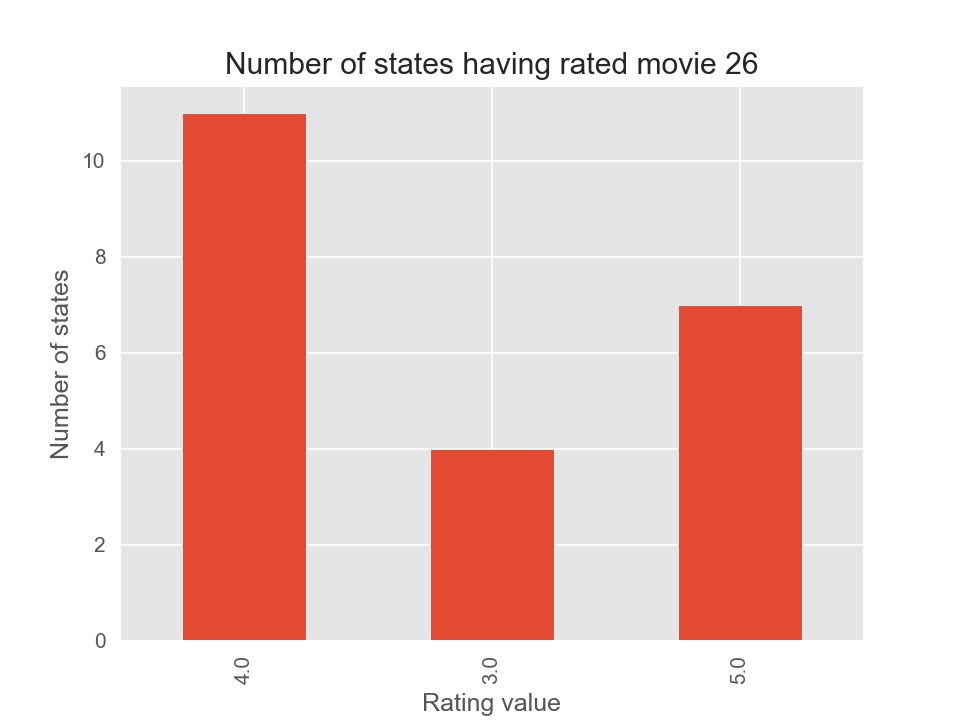

Text(0.5, 1.0, 'Number of states having rated movie 26')

In [259]:
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
matplotlib.style.use('ggplot')

counter = Counter([r for (_, r) in trainset_co.ir[trainset_co.to_inner_iid(26)]])
pd.DataFrame.from_dict(counter, orient='index').plot(kind='bar', legend=False)
plt.xlabel('Rating value')
plt.ylabel('Number of states')
plt.title('Number of states having rated movie 26')

Best and worst prediction of SVDpp

In [244]:
data_svd= Dataset.load_from_df(ratings2[['state_id', 'movie', 'avg_rating']], reader)
trainset_svd, testset_svd = train_test_split(data_svd, test_size=0.25)
algo_svd = SVDpp(n_epochs= 20, lr_all= 0.006, reg_all= 0.4)
predictions_svd = algo_svd.fit(trainset_svd).test(testset_svd)
accuracy.rmse(predictions_svd)

RMSE: 0.6743


0.6742921672138539

In [246]:
def get_Iu(uid):
    try:
        return len(trainset_svd.ur[trainset_svd.to_inner_uid(uid)])
    except ValueError: 
        return 0
    
def get_Ui(iid):
    try: 
        return len(trainset_svd.ir[trainset_svd.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions_svd, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions_svd = df.sort_values(by='err')[:10]
worst_predictions_svd = df.sort_values(by='err')[-10:]

In [247]:
best_predictions_svd

,uid,iid,rui,est,details,Iu,Ui,err
234,0,2,4.0,4.000747,{'was_impossible': False},41,28,0.000747
82,5,104,4.0,3.997788,{'was_impossible': False},75,21,0.002212
473,30,27,4.0,4.002289,{'was_impossible': False},88,23,0.002289
848,3,7,4.0,3.997444,{'was_impossible': False},92,33,0.002556
224,4,76,4.0,4.002736,{'was_impossible': False},86,23,0.002736
792,19,75,4.0,3.996943,{'was_impossible': False},84,22,0.003057
912,3,75,4.0,3.996351,{'was_impossible': False},92,22,0.003649
615,30,108,4.0,4.004727,{'was_impossible': False},88,23,0.004727
425,29,19,4.0,3.995117,{'was_impossible': False},77,28,0.004883
247,4,56,4.0,3.994547,{'was_impossible': False},86,23,0.005453


In [248]:
worst_predictions_svd

,uid,iid,rui,est,details,Iu,Ui,err
610,21,112,5.0,3.088610,{'was_impossible': False},81,25,1.911390
775,16,111,2.0,3.939366,{'was_impossible': False},72,23,1.939366
958,35,5,2.0,4.075763,{'was_impossible': False},56,22,2.075763
678,1,98,1.0,3.150087,{'was_impossible': False},77,23,2.150087
396,1,81,2.0,4.151547,{'was_impossible': False},77,22,2.151547
909,9,56,2.0,4.155861,{'was_impossible': False},43,23,2.155861
530,16,22,1.0,3.304287,{'was_impossible': False},72,27,2.304287
509,22,20,1.0,3.692094,{'was_impossible': False},85,20,2.692094
960,28,35,1.0,3.895299,{'was_impossible': False},80,20,2.895299
908,24,71,1.0,3.946189,{'was_impossible': False},13,25,2.946189


<IPython.core.display.Javascript object>


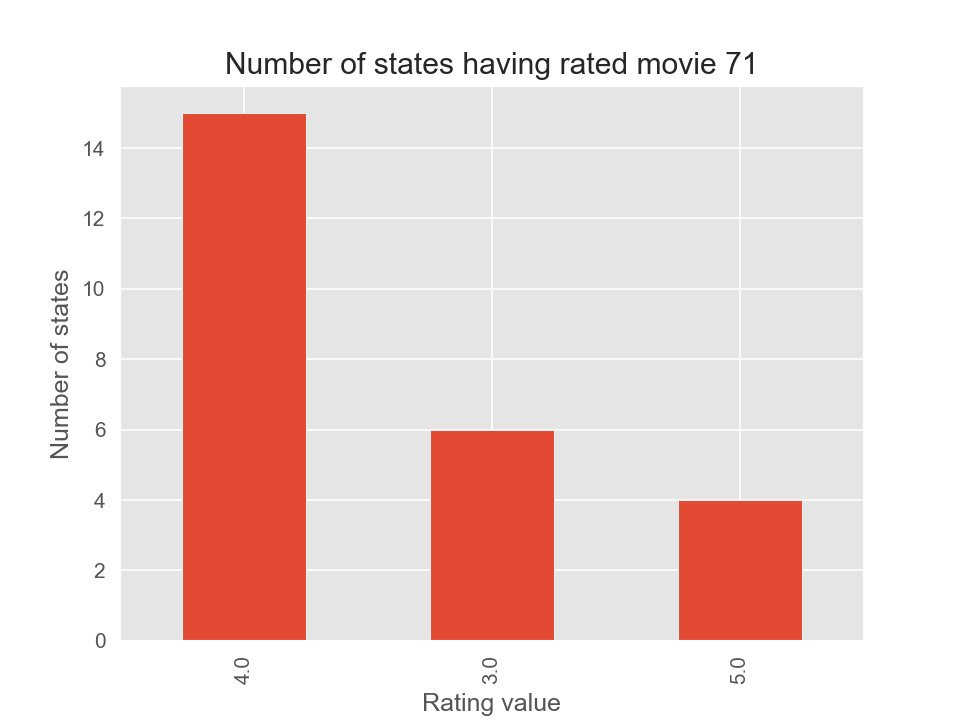

Text(0.5, 1.0, 'Number of states having rated movie 71')

In [257]:
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
matplotlib.style.use('ggplot')

counter = Counter([r for (_, r) in trainset_svd.ir[trainset_svd.to_inner_iid(71)]])
pd.DataFrame.from_dict(counter, orient='index').plot(kind='bar', legend=False)
plt.xlabel('Rating value')
plt.ylabel('Number of states')
plt.title('Number of states having rated movie 71')

Best and worst prediction of BaselineOnly

In [226]:
data_final= Dataset.load_from_df(ratings2[['state_id', 'movie', 'avg_rating']], reader)
trainset, testset = train_test_split(data_final, test_size=0.25)
bsl_options = {'method': 'als', 'n_epochs': 20, 'lr_all': 0.006, 'reg_all': 0.4}
algo_final = BaselineOnly(bsl_options=bsl_options)
predictions = algo_final.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.6896


0.6895806706234501

In [227]:
def get_Iu(uid):
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: 
        return 0
    
def get_Ui(iid):
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [228]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
787,17,90,4.0,4.000226,{'was_impossible': False},86,23,0.000226
495,12,2,4.0,3.999688,{'was_impossible': False},92,28,0.000312
369,4,91,4.0,3.999521,{'was_impossible': False},80,27,0.000479
616,7,75,4.0,4.000488,{'was_impossible': False},85,26,0.000488
230,18,80,4.0,3.998546,{'was_impossible': False},91,25,0.001454
231,8,28,4.0,3.998468,{'was_impossible': False},83,25,0.001532
293,23,73,4.0,4.001788,{'was_impossible': False},76,22,0.001788
374,30,33,4.0,3.998148,{'was_impossible': False},85,28,0.001852
872,30,29,4.0,4.002248,{'was_impossible': False},85,24,0.002248
748,22,4,4.0,4.004751,{'was_impossible': False},86,27,0.004751


In [229]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
411,7,34,1.0,3.257901,{'was_impossible': False},85,25,2.257901
772,20,43,1.0,3.261421,{'was_impossible': False},78,27,2.261421
835,21,45,1.0,3.398116,{'was_impossible': False},85,22,2.398116
180,22,20,1.0,3.616592,{'was_impossible': False},86,22,2.616592
168,15,13,1.0,3.683416,{'was_impossible': False},42,29,2.683416
447,13,45,1.0,3.727233,{'was_impossible': False},83,22,2.727233
695,13,38,1.0,3.860892,{'was_impossible': False},83,27,2.860892
212,7,18,1.0,3.960522,{'was_impossible': False},85,23,2.960522
314,39,57,1.0,4.002238,{'was_impossible': False},75,29,3.002238
352,32,79,1.0,4.160267,{'was_impossible': False},41,30,3.160267


Inspecting into the worst rating of a movie.. do it for other algos aswell

<IPython.core.display.Javascript object>


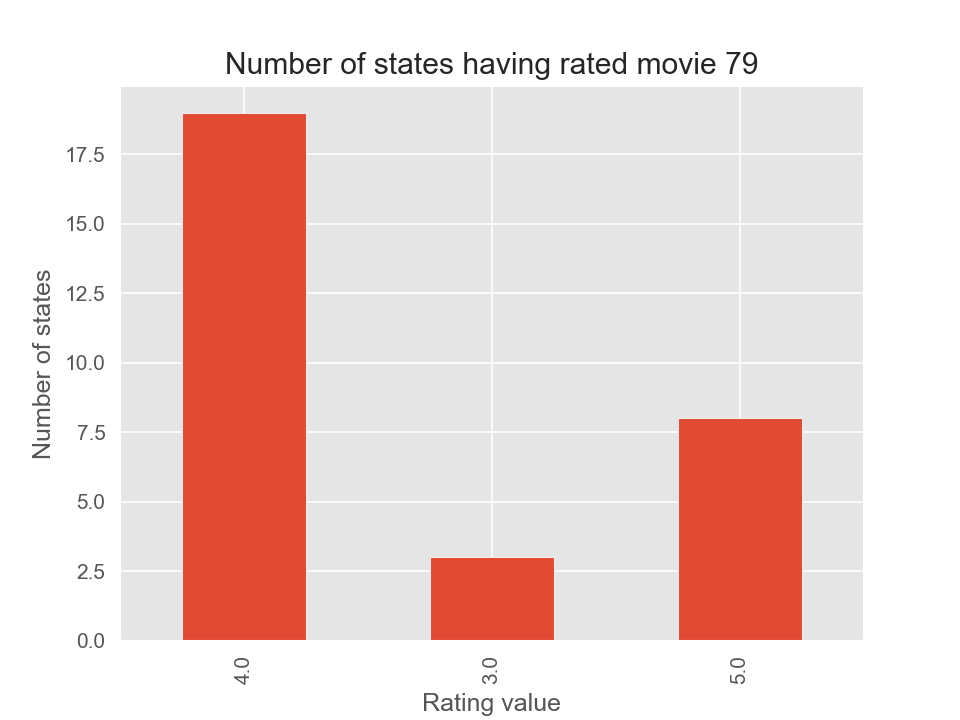

Text(0.5, 1.0, 'Number of states having rated movie 79')

In [237]:
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
matplotlib.style.use('ggplot')

counter = Counter([r for (_, r) in trainset.ir[trainset.to_inner_iid(79)]])
pd.DataFrame.from_dict(counter, orient='index').plot(kind='bar', legend=False)
plt.xlabel('Rating value')
plt.ylabel('Number of states')
plt.title('Number of states having rated movie 79')

# Final Model

In [240]:
state=list(ratings2.state_id.unique())
movie=list(ratings2.movie.unique())


def Recommend(state):
    recommendation=[]
    rec=pd.DataFrame(columns=['user','item', 'est'])
    data_final= Dataset.load_from_df(ratings2[['state_id', 'movie', 'avg_rating']], reader)
    trainset = data_final.build_full_trainset()
    bsl_options = {'method': 'als', 'n_epochs': 20, 'reg_u': 0.4, 'reg_i':0.4}
    algo_final = BaselineOnly(bsl_options=bsl_options, verbose=True)
    algo_final.fit(trainset)
    for m in movie:
        recommendation.append(algo_final.predict(state, m, verbose=True))
        rec=pd.DataFrame(recommendation)
        rec=rec.sort_values(by=['est'], ascending=False).head(10)
#         recommendation=sorted(recommendation, key=lambda est: est.modified, reverse=True)
    return rec
    

In [241]:
Recommend(1)

Estimating biases using als...
user: 1          item: 0          r_ui = None   est = 4.14   {'was_impossible': False}
user: 1          item: 1          r_ui = None   est = 3.25   {'was_impossible': False}
user: 1          item: 2          r_ui = None   est = 4.11   {'was_impossible': False}
user: 1          item: 3          r_ui = None   est = 4.24   {'was_impossible': False}
user: 1          item: 4          r_ui = None   est = 4.29   {'was_impossible': False}
user: 1          item: 5          r_ui = None   est = 3.63   {'was_impossible': False}
user: 1          item: 6          r_ui = None   est = 4.53   {'was_impossible': False}
user: 1          item: 7          r_ui = None   est = 4.22   {'was_impossible': False}
user: 1          item: 8          r_ui = None   est = 4.06   {'was_impossible': False}
user: 1          item: 9          r_ui = None   est = 4.10   {'was_impossible': False}
user: 1          item: 10         r_ui = None   est = 3.76   {'was_impossible': False}
user: 1     

,uid,iid,r_ui,est,details
107,1,107,None,4.791498,{'was_impossible': False}
73,1,73,None,4.672291,{'was_impossible': False}
110,1,110,None,4.659945,{'was_impossible': False}
96,1,96,None,4.655098,{'was_impossible': False}
62,1,62,None,4.595668,{'was_impossible': False}
69,1,69,None,4.557007,{'was_impossible': False}
111,1,111,None,4.548734,{'was_impossible': False}
65,1,65,None,4.543548,{'was_impossible': False}
6,1,6,None,4.531715,{'was_impossible': False}
39,1,39,None,4.514599,{'was_impossible': False}
